# Data processing and stochastic modelization

In [1]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

#Home made functions
import Utilities

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -2 #Maximal number of cores in use
extension = '.png' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#♦DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop
CASE   = 'Bentheimer1000'

In [2]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

def time_step_analysis(t_ssl,key) :
    dt         = [t1-t0 for (t1,t0) in zip(t_ssl[1:],t_ssl[:-1]) if t1-t0 > 0]
    dt_hist    = Extract_pdf(dt,50)
    dtDNS_mean = np.mean(dt)
    dtDNS_std  = np.std(dt)
    return (key, dt_hist, dtDNS_mean, dtDNS_std)
    
def parallel_time_step_analysis(t_dict) :
    dt_hist        = {}
    dtDNS_mean     = {}
    dtDNS_std      = {}
    results  = Parallel(n_jobs=NCORES_MAX)(delayed(time_step_analysis)(t_dict[key],key) for key in KEYS)
    for (k_,h_,m_,s_) in results :
        dt_hist[k_]    = h_.tolist()
        dtDNS_mean[k_] = [m_]
        dtDNS_std[k_]  = [s_]
    return dt_hist, dtDNS_mean, dtDNS_std

## Some useful functions to handle pdf
def Save_pdf(pdf_dict, filename) :
    #Copy data into non np array dict for json formating
    x = {}
    y = {}
    for key in pdf_dict : x[key] = [v for v in pdf_dict[key][0]]
    for key in pdf_dict : y[key] = [v for v in pdf_dict[key][1]]
    with open(filename, 'w') as outfile:  
        json.dump([x,y], outfile)
        
def Load_pdf(filename) :
    x = {}
    y = {} 
    pdf_ = {}
    with open(filename, 'r') as outfile:  
        data = json.load(outfile)
    x = data[0]
    y = data[1]
    for key in x : pdf_[key] = [np.array(x[key]),np.array(y[key])]    
    return pdf_

def Extract_pdf(data_, nbins = 500, dst = True) :
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

def Return_skew(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu   = Return_mean(pdf_)
    std  = Return_std(pdf_)
    skew = np.sum([((x_ - mu)/std)**3*y_ for (x_,y_) in zip(x,y)])/np.sum(y)
    return skew

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_



In [3]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

#### Data files 

In [4]:
DATA = {}

#Results with CSF = 1
DM_1  = ['0.0E0']
KEYS_1 = ['Bent 1000, D='+dm+', CSF=1' for dm in DM_1]
for dm in DM_1 : DATA['Bent 1000, D='+dm+', CSF=1'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM20000_TMAX0_CSF1.dat'
PLOT_KEYS_1 = ['Bent 1000, D='+dm_+', CSF=1' for dm_ in DM_1]

#Results with CSF = 40
DM_40 = ['0.0E0',
       '1.0E-13',
       '2.0E-13', 
       '5.0E-13', 
       '1.0E-12',
       '2.0E-12', 
       '5.0E-12', 
       '1.0E-11', 
       '2.0E-11', 
       '5.0E-11', 
       '1.0E-10',
       '2.0E-10',
       '5.0E-10',
       '1.0E-9',
       '1.0E-8',
       '1.0E-7',
       '1.0E-6',
       '1.0E-5']
KEYS_40   = ['Bent 1000, D='+dm+', CSF=40' for dm in DM_40] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
for dm in DM_40 : DATA['Bent 1000, D='+dm+', CSF=40'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM0_TMAX2.0E7_CSF40.dat'
PLOT_KEYS_40 = ['Bent 1000, D='+dm_+', CSF=40' for dm_ in ['0.0E0','1.0E-13','1.0E-11','1.0E-9','1.0E-8','1.0E-7','1.0E-6','1.0E-5']]

#Results with CSF = 40
DM_300 = ['0.0E0',
       '1.0E-13',
       '1.0E-12',
       '1.0E-11', 
       '1.0E-10',
       '1.0E-9',
       '1.0E-8']
KEYS_300 = ['Bent 1000, D='+dm+', CSF=300' for dm in DM_300] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
for dm in DM_300 : DATA['Bent 1000, D='+dm+', CSF=300'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM0_TMAX1.0E8_CSF300.dat'
PLOT_KEYS_300 = ['Bent 1000, D='+dm_+', CSF=300' for dm_ in DM_300]

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA)))

KEYS = KEYS_1 + KEYS_40 + KEYS_300
PARAM = {}
param = ['DM','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key], param)
D_VALUES_1   = [PARAM[key]['DM'] for key in KEYS_1]
D_VALUES_40  = [PARAM[key]['DM'] for key in KEYS_40]
D_VALUES_300 = [PARAM[key]['DM'] for key in KEYS_300]    
D_VALUES     = D_VALUES_1 + D_VALUES_40 + D_VALUES_300

CSF_VALUES = ['1','40','300']
KEYS_CSF = {'1' : KEYS_1, '40' : KEYS_40, '300' : KEYS_300}

for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + ' :')
        print('\t' + DATA[key])
        print('not found')

Dataset to load : 26


# Loading and processing DNS data

##### Computing Ux mean from Eulerian velocities

In [5]:
UMEAN = {}
Ndat  = 1000
if (not os.path.isfile(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')) :
    phi   = Bentheimer1000['phi']
    print('-load ux data..')
    ux    = np.loadtxt(DIR+'Bentheimer'+str(Ndat)+'/Ux.dat')
    print('-Ux dimensions : '+str(np.shape(ux)))
 
    #First method to find Umean (direct mesh computation)
    print('-first method..')
    Umean = np.mean(ux[:][0]) #Mean flow velocity as the mean over the first yz section of the domain
    UMEAN['dmc'] = [Umean]

    #Second method (From Fortran code)
    print('-reshaping ux..')
    uux = ux.reshape(Ndat**3)
    del ux
    Umean = 0
    print('-second method..')
    for (i2,i3) in zip(range(Ndat),range(Ndat)) :
        i1 = 0
        Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
    Umean = Umean/(Ndat**2)/phi
    UMEAN['fortran'] = [Umean]
    Save_data(UMEAN,DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    del uux
else :
    UMEAN = Load_data(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    
print('=> Umean fortran = ' + str(UMEAN['fortran']) + '\t Umean dmc = ' + str(UMEAN['dmc']))
Umean = UMEAN['fortran'][0]

=> Umean fortran = [2.4514361e-09]	 Umean dmc = [7.17953958e-09]


#### Computing log velocity magnitude $$v = \ln{\left(\frac{\sqrt{u_x^2 + u_y^2 + u_z^2}}{U}\right)}$$

In [6]:
vDNS = {}; 
tDNS = {}; 
for CSF_ in CSF_VALUES :
    vfname = DIR+'Processed_data/vDNS_CSF'+CSF_+'.dat'
    tfname = DIR+'Processed_data/tDNS_CSF'+CSF_+'.dat'
    if os.path.isfile(vfname) and os.path.isfile(tfname) and (not RERUN): 
        print('Loading vDNS CSF '+ CSF_ +' ..')
        tmp = Load_data(vfname)
        for key in tmp : vDNS[key] = tmp[key]
        print('Loading tDNS CSF '+ CSF_ +' ..')
        tmp = Load_data(tfname)
        for key in tmp : tDNS[key] = tmp[key]
        print('Done.')
    else :
        print('Files not found.')

Loading vDNS CSF 1 ..
Loading tDNS CSF 1 ..
Done.
Loading vDNS CSF 40 ..
Loading tDNS CSF 40 ..
Done.
Loading vDNS CSF 300 ..
Loading tDNS CSF 300 ..
Done.


In [7]:
Umean  =1.0;
pvx_DNS = {}; pdfvxfname = DIR+'Processed_data/pdf_vx.dat'
pvy_DNS = {}; pdfvyfname = DIR+'Processed_data/pdf_vy.dat'
pvz_DNS = {}; pdfvzfname = DIR+'Processed_data/pdf_vz.dat'
if os.path.isfile(pdfvxfname):  pvx_DNS = Load_pdf(pdfvxfname)
if os.path.isfile(pdfvyfname):  pvy_DNS = Load_pdf(pdfvyfname)
if os.path.isfile(pdfvzfname):  pvz_DNS = Load_pdf(pdfvzfname)

In [8]:
for CSF_ in CSF_VALUES :
    print('Checking if new data file...')
    SAVE_LVM = False
    SAVE_PDF = False
    for key in KEYS_CSF[CSF_] :
        if (key not in vDNS) or (key not in pvx_DNS) :
            print(key+' not found..')
            RESAVE = True
            with open(DATA[key], 'r') as f:
                dataDNS = np.loadtxt((line for line in f if (len(line)>100 and len(line)<150)))
            tDNS[key] = dataDNS[:,0]
            print(key + '\t: NtDNS = '+str(len(tDNS[key])))
            
            ## LVM
            if (key not in vDNS) :
                print("missing " + key + " in LVM ..")
                SAVE_LVM = True
                vDNS[key] = np.array(
                    [np.log(np.sqrt(ux**2+uy**2+uz**2)) 
                        for (ux,uy,uz) in zip(dataDNS[:,4], dataDNS[:,5], dataDNS[:,6]) 
                        if np.sqrt(ux**2+uy**2+uz**2) > 0])  
            
            ## DIRECTIONAL PDFs
            if (key not in pvx_DNS) :
                print("missing " + key + " in PDF ..")
                SAVE_PDF = True
                pvx_DNS[key] = Extract_pdf(dataDNS[:,4]/Umean)
                pvy_DNS[key] = Extract_pdf(dataDNS[:,5]/Umean)
                pvz_DNS[key] = Extract_pdf(dataDNS[:,6]/Umean)
        
            #free memspace
            del dataDNS
        
    if SAVE_LVM :
        print('Saving LVM...')
        tosave = {k_ : vDNS[k_] for k_ in KEYS_CSF[CSF_]}
        Save_data(vtosave,DIR+'Processed_data/vDNS_CSF'+CSF_+'.dat')
        tosave = {k_ : tDNS[k_] for k_ in KEYS_CSF[CSF_]}
        Save_data(ttosave,DIR+'Processed_data/tDNS_CSF'+CSF_+'.dat')
        vtosave = ttosave = {}

Checking if new data file...
Checking if new data file...
Checking if new data file...


In [9]:
if True :
    print('Saving PDF..')
    Save_pdf(pvx_DNS,pdfvxfname)
    Save_pdf(pvy_DNS,pdfvyfname)
    Save_pdf(pvz_DNS,pdfvzfname)
print('Done.') 
for key in pvx_DNS : print(key)

Saving PDF..
Done.
Bent 1000, D=0.0E0, CSF=40
Bent 1000, D=0.0E1, CSF=40
Bent 1000, D=1.0E-13, CSF=40
Bent 1000, D=2.0E-13, CSF=40
Bent 1000, D=5.0E-13, CSF=40
Bent 1000, D=1.0E-12, CSF=40
Bent 1000, D=2.0E-12, CSF=40
Bent 1000, D=5.0E-12, CSF=40
Bent 1000, D=1.0E-11, CSF=40
Bent 1000, D=2.0E-11, CSF=40
Bent 1000, D=5.0E-11, CSF=40
Bent 1000, D=1.0E-10, CSF=40
Bent 1000, D=2.0E-10, CSF=40
Bent 1000, D=5.0E-10, CSF=40
Bent 1000, D=1.0E-9, CSF=40
Bent 1000, D=1.0E-8, CSF=40
Bent 1000, D=1.0E-7, CSF=40
Bent 1000, D=1.0E-6, CSF=40
Bent 1000, D=1.0E-5, CSF=40
Bent 1000, D=1.0E-9, CSF=500
Bent 1000, D=1.0E-13, CSF=300
Bent 1000, D=0.0E0, CSF=300
Bent 1000, D=1.0E-12, CSF=300
Bent 1000, D=1.0E-11, CSF=300
Bent 1000, D=1.0E-10, CSF=300
Bent 1000, D=1.0E-9, CSF=300
Bent 1000, D=1.0E-8, CSF=300
Bent 1000, D=0.0E0, CSF=1


#### Overview of the rough DNS time

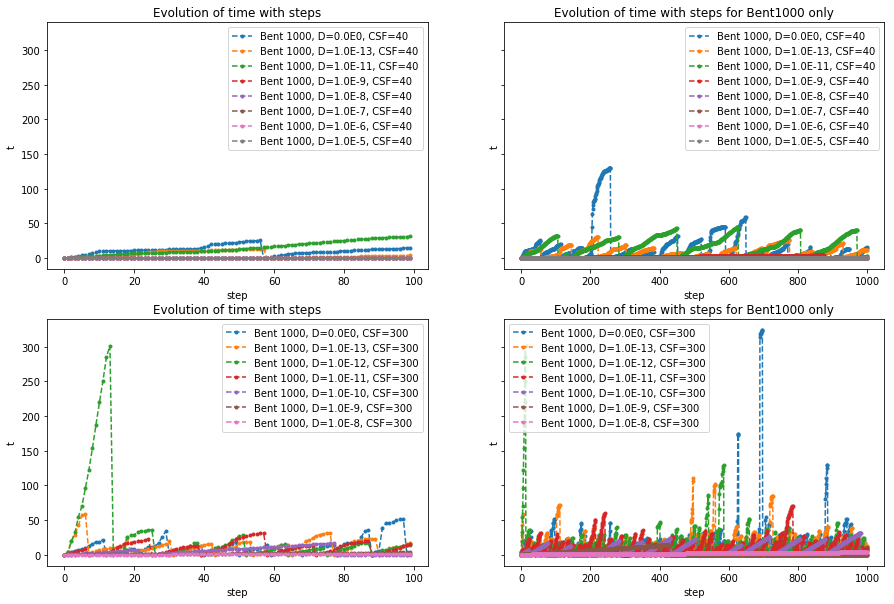

In [10]:
fig, axs = plt.subplots(2,2, figsize=(15,10), sharey = True)

PLOT_KEYS = PLOT_KEYS_40
ax = axs[0,0]
ax.set_title('Evolution of time with steps');
for key in PLOT_KEYS : ax.plot(tDNS[key][range(100)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();

ax = axs[0,1]
ax.set_title('Evolution of time with steps for Bent1000 only');
for key in PLOT_KEYS : ax.plot(tDNS[key][range(1000)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();

PLOT_KEYS = PLOT_KEYS_300
ax = axs[1,0]
ax.set_title('Evolution of time with steps');
for key in PLOT_KEYS : ax.plot(tDNS[key][range(100)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();

ax = axs[1,1]
ax.set_title('Evolution of time with steps for Bent1000 only');
for key in PLOT_KEYS : ax.plot(tDNS[key][range(1000)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();
plt.savefig(DIR+'Figures/DNS_time'+extension)

## Making DNS data isochronous

### 1) Single streamline transform (ssl)

In [37]:
def ssl_transform_old(N,t,v) :
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering step between two s.l.
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    v_ssl   = np.zeros(N_ssl)
    #t_ssl  = [t_ssl[i-1] + dt_ssl[i] for i in range(1,N_ssl)]
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
        v_ssl[i] = v[i]
    return t_ssl, v_ssl

def ssl_transform_new(N,tDNS,vDNS) :
    t_ssl   = []
    v_ssl   = []
    told    = 0.0
    T       = 0.0
    for  (t_,v_) in zip(tDNS,vDNS) :
        if t_ >= told :
            T += t_ - told
            t_ssl.append(T)
            v_ssl.append(v_)
        told = t_
    return np.array(t_ssl), np.array(v_ssl)

In [41]:
key = KEYS[1]
t_ = tDNS[key]; v_ = vDNS[key]
start = time.time()
t_serie, v_serie = ssl_transform_old (len(t_),t_, v_)
end   = time.time()
print('old : vmean = ' + str(np.mean(v_serie)) + ', Npoints = '+ str(len(t_serie)) + ', time needed : '+str(end-start))

old : vmean = 1.1862782199266253, Npoints = 11167030, time needed : 9.996272325515747


In [38]:
start = time.time()
t_serie, v_serie = ssl_transform_new (len(t_),t_, v_)
end   = time.time()
print('new : vmean = ' + str(np.mean(v_serie)) + ', Npoints = '+ str(len(t_serie)) + ', time needed : '+str(end-start))

old : vmean = 1.1862782199266253, Npoints = 11167030, time needed : 9.954451560974121
new : vmean = 1.1858547350794832, Npoints = 11167031, time needed : 6.895624399185181


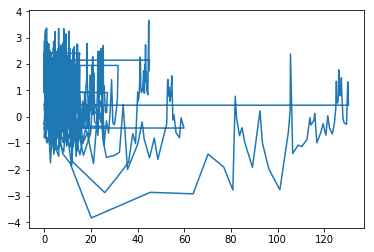

In [39]:
plt.plot(tDNS[key][range(1000)],vDNS[key][range(1000)])
#plt.plot(t_serie[range(1000)],v_serie[range(1000)])

In [42]:
N = len(t_serie)-1
Nt_iso   = int(np.ceil(t_serie[N]/dt))
v_iso    = np.zeros(Nt_iso)
    
m = 0; i = 0; ti = 0;
while(m < N-1) :
    t1 = t_serie[m+1]; t0 = t_serie[m]
    v1 = v_serie[m+1]; v0 = v_serie[m]
    while (t0 <= ti <= t1) :
        v_iso[i]  = lin_interp(v1,t1,v0,t0,ti)
        ti += dt; i += 1
    m = m + 1
print(np.mean(v_iso))

KeyboardInterrupt: 

Reading existing data

In [12]:
'''
dicts      = [{},{}]
v_ssl   = dicts[0];
t_ssl   = dicts[1];

for CSF_ in CSF_VALUES :
    vsslfname   = DIR+'Processed_data/v_ssl_CSF'+CSF_+'.dat'
    tsslfname   = DIR+'Processed_data/t_ssl_CSF'+CSF_+'.dat'
    if os.path.isfile(vsslfname): 
        print('Loading ' + vsslfname + '..')
        tmp = Load_data(vsslfname)
        for key in tmp : v_ssl[key] = tmp[key]
    if os.path.isfile(tsslfname): 
        print('Loading ' + tsslfname + '..')
        tmp = Load_data(tsslfname)
        for key in tmp : t_ssl[key] = tmp[key]    
'''

"\ndicts      = [{},{}]\nv_ssl   = dicts[0];\nt_ssl   = dicts[1];\n\nfor CSF_ in CSF_VALUES :\n    vsslfname   = DIR+'Processed_data/v_ssl_CSF'+CSF_+'.dat'\n    tsslfname   = DIR+'Processed_data/t_ssl_CSF'+CSF_+'.dat'\n    if os.path.isfile(vsslfname): \n        print('Loading ' + vsslfname + '..')\n        tmp = Load_data(vsslfname)\n        for key in tmp : v_ssl[key] = tmp[key]\n    if os.path.isfile(tsslfname): \n        print('Loading ' + tsslfname + '..')\n        tmp = Load_data(tsslfname)\n        for key in tmp : t_ssl[key] = tmp[key]    \n"

Computing what's missing

In [13]:
'''
for CSF_ in CSF_VALUES :
    vsslfname   = DIR+'Processed_data/v_ssl_CSF'+CSF_+'.dat'
    tsslfname   = DIR+'Processed_data/t_ssl_CSF'+CSF_+'.dat'
    RESAVE = False
    print('Checking if new data file...')
    for key in DATA :
        if key not in v_ssl :
            RESAVE = True
            print("missing " + key + " data..")
            Npoints = len(tDNS[key]) #For the full data set
            t_ssl[key], v_ssl[key] = ssl_transform (Npoints, tDNS[key], vDNS[key])
            print (key + '\t Npoints = '+str(Npoints))
            print('t_ssl : '+str(len(t_ssl[key]))+', v_ssl : ' + str(len(v_ssl[key])))
    print('Done.')
    if RESAVE :
        print('Saving '+vsslfname+'...')
        tosave = {k_ : v_ssl[k_] for k_ in KEYS_CSF[CSF_]}
        Save_data(v_ssl,vsslfname)
        print('Saving '+tsslfname+'...')
        tosave = {k_ : t_ssl[k_] for k_ in KEYS_CSF[CSF_]}
        Save_data(t_ssl,tsslfname)
        tosave = {}
print('Done.')    
'''

'\nfor CSF_ in CSF_VALUES :\n    vsslfname   = DIR+\'Processed_data/v_ssl_CSF\'+CSF_+\'.dat\'\n    tsslfname   = DIR+\'Processed_data/t_ssl_CSF\'+CSF_+\'.dat\'\n    RESAVE = False\n    print(\'Checking if new data file...\')\n    for key in DATA :\n        if key not in v_ssl :\n            RESAVE = True\n            print("missing " + key + " data..")\n            Npoints = len(tDNS[key]) #For the full data set\n            t_ssl[key], v_ssl[key] = ssl_transform (Npoints, tDNS[key], vDNS[key])\n            print (key + \'\t Npoints = \'+str(Npoints))\n            print(\'t_ssl : \'+str(len(t_ssl[key]))+\', v_ssl : \' + str(len(v_ssl[key])))\n    print(\'Done.\')\n    if RESAVE :\n        print(\'Saving \'+vsslfname+\'...\')\n        tosave = {k_ : v_ssl[k_] for k_ in KEYS_CSF[CSF_]}\n        Save_data(v_ssl,vsslfname)\n        print(\'Saving \'+tsslfname+\'...\')\n        tosave = {k_ : t_ssl[k_] for k_ in KEYS_CSF[CSF_]}\n        Save_data(t_ssl,tsslfname)\n        tosave = {}\nprint

#### Distribution of time step 

In [14]:
dt_histfname = DIR+'Processed_data/dt_hist.dat'
dtmeanfname  = DIR+'Processed_data/dt_mean.dat'
dtstdfname   = DIR+'Processed_data/dt_std.dat'
dt_hist = {}; dtDNS_mean = {}; dtDNS_std = {};
print('Loading data...')
if os.path.isfile(dt_histfname) : dt_hist    = Load_pdf(dt_histfname)
if os.path.isfile(dtmeanfname)  : dtDNS_mean = Load_data(dtmeanfname)
if os.path.isfile(dtstdfname)   : dtDNS_std  = Load_data(dtstdfname)
print('Done.')

RESAVE = False
for key in tDNS :
    if (key not in dt_hist) or (key not in dtDNS_mean) or (key not in dtDNS_std) :
        RESAVE = True
        print("missing " + key + " data..")        
        k_,h_,m_,s_ = time_step_analysis(tDNS[key],key)
        dt_hist[key]    = h_.tolist()
        dtDNS_mean[key] = [m_]
        dtDNS_std[key]  = [s_]
        
if RESAVE :
    print('Saving '+dt_histfname+'...')
    Save_pdf(dt_hist,dt_histfname)
    print('Saving '+dtmeanfname+'...')
    Save_data(dtDNS_mean,dtmeanfname)
    print('Saving '+dtstdfname+'...')
    Save_data(dtDNS_std,dtstdfname)
    print('Done.') 

Loading data...
Done.


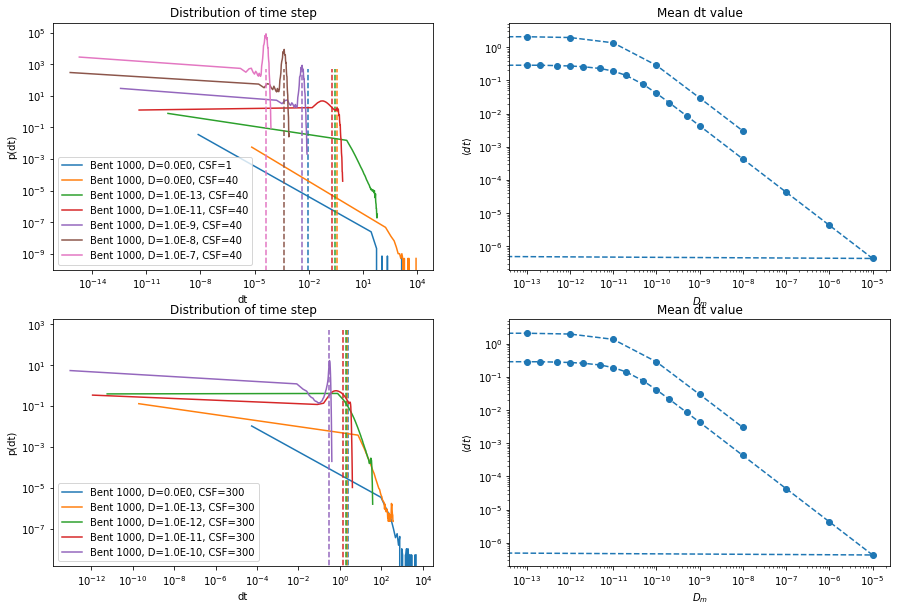

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

PLOT_KEYS = PLOT_KEYS_1 + PLOT_KEYS_40
ax = axs[0,0]
k_ = 0
for key in PLOT_KEYS[0:-2] :
    ax.plot(dt_hist[key][0],dt_hist[key][1], label = key, color = color_cycle[k_])
    ax.plot(np.ones(2) * dtDNS_mean[key],np.linspace(0,500,2),'--', color = color_cycle[k_])
    k_ += 1
ax.set_title('Distribution of time step');
ax.set_xlabel('dt')
ax.set_ylabel('p(dt)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

ax = axs[0,1]
ax.set_title('Mean dt value')
ax.plot(D_VALUES,[dtDNS_mean[k_] for k_ in KEYS],'o--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_m$')
ax.set_ylabel(r'$\langle dt \rangle$')

PLOT_KEYS = PLOT_KEYS_300
ax = axs[1,0]
k_ = 0
for key in PLOT_KEYS[0:-2] :
    ax.plot(dt_hist[key][0],dt_hist[key][1], label = key, color = color_cycle[k_])
    ax.plot(np.ones(2) * dtDNS_mean[key],np.linspace(0,500,2),'--', color = color_cycle[k_])
    k_ += 1
ax.set_title('Distribution of time step');
ax.set_xlabel('dt')
ax.set_ylabel('p(dt)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

ax = axs[1,1]
ax.set_title('Mean dt value')
ax.plot(D_VALUES,[dtDNS_mean[k_] for k_ in KEYS],'o--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_m$')
ax.set_ylabel(r'$\langle dt \rangle$')

plt.savefig(DIR+'Figures/DNS_dt_distribution'+extension)

#### Overview of the ssl transformed DNS serie

In [16]:
'''
fig, ax = plt.subplots(1,1, figsize=(7.5,5))

ax.set_title('Time evolution after ssl transform')
for key in PLOT_KEYS : ax.plot(t_ssl[key][range(0,len(t_ssl[key]),1000)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();
plt.savefig(DIR+'Figures/DNS_time_iso'+extension)
'''

"\nfig, ax = plt.subplots(1,1, figsize=(7.5,5))\n\nax.set_title('Time evolution after ssl transform')\nfor key in PLOT_KEYS : ax.plot(t_ssl[key][range(0,len(t_ssl[key]),1000)],'.--', label = key);\nax.set_xlabel('step');\nax.set_ylabel('t');\nax.legend();\nplt.savefig(DIR+'Figures/DNS_time_iso'+extension)\n"

#### Isochronous transform of DNS data

In [30]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v
#Alternative version (parallel over dict keys) :
def isochronous_transform(t_, v_, dt, key, Npoints) :
    t_serie, v_serie = ssl_transform_new (len(t_),t_, v_)
    if Npoints == 'all' :
        N = len(t_serie)-1
    elif 0 < Npoints <= 1 :
        N = int(Npoints * (len(t_serie)-1))
    else :
        N = Npoints
    Nt_iso   = int(np.ceil(t_serie[N]/dt))
    v_iso    = np.zeros(Nt_iso)
    
    m = 0; i = 0; ti = 0;
    while(m < N-1) :
        t1 = t_serie[m+1]; t0 = t_serie[m]
        v1 = v_serie[m+1]; v0 = v_serie[m]
        while (t0 <= ti <= t1) :
            v_iso[i]  = lin_interp(v1,t1,v0,t0,ti)
            ti += dt; i += 1
        m = m + 1
    return (key,v_iso)

def parallel_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor, MISSING_KEYS) :
    v_iso    = Parallel(n_jobs=NCORES_MAX)(
        delayed(isochronous_transform)
        (t_dict[key], v_dict[key], dt_dict[key][0] * dt_factor, key, Npoints) for key in MISSING_KEYS)
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

def sequential_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor) :
    v_iso = [isochronous_transform(t_dict[key], v_dict[key], dt_dict[key] * dt_factor, key, Npoints) for key in KEYS]
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

Reading existing data

In [43]:
#Dictionnary to store isochronous transforms with various dt
dt_factor = 1.0 #To choose the ratio between isochr dt and DNS mean dt
v_iso  = {}; 
t_iso  = {} #time (linspace(0,T,dt))
Nt_iso = {} #number of points
dt_iso = {}; 
Npoints = 'all'

In [19]:
for CSF_ in CSF_VALUES :
    vname = DIR+'Processed_data/v_iso_dt_fact_'+str(dt_factor)+'_CSF'+CSF_+'.dat'
    dtname = DIR+'Processed_data/dt_iso_dt_fact_'+str(dt_factor)+'_CSF'+CSF_+'.dat'
    if  os.path.isfile(vname) :
        print('Loading v_iso.dat...')
        v_iso = Load_data(vname)
    if  os.path.isfile(vname) :
        print('Loading dt_iso.dat...')
        dt_iso = Load_data(dtname)
print('Done.')

Loading v_iso.dat...


JSONDecodeError: Expecting ',' delimiter: line 1 column 27461445 (char 27461444)

Computing what's missing

In [44]:
RESAVE = False
MISSING_KEYS = [] 
for key in KEYS : 
    if key not in v_iso : 
        MISSING_KEYS.append(key)

if MISSING_KEYS :
    RESAVE = True
    print('Isochronous transform..')
    start = time.time()
    v_iso_missing  = parallel_isochronous_transform(tDNS, vDNS, dtDNS_mean, Npoints, dt_factor, MISSING_KEYS)
    for key in v_iso_missing :
        v_iso[key] = v_iso_missing[key]
    end = time.time()
    print('\tTime needed \t: '+str(end-start))
    for key in KEYS :
        print(key+' :')
        Nt_iso[key]  = len(v_iso[key])
        dt  = dtDNS_mean[key][0]
        dt_iso[key] = [dt*dt_factor]
        dt_iso[key] = dt_iso[key]
        print('\t dt = '+str(dt))
        print('\t Nt_DNS = '+str(len(tDNS[key])))
        print('\t Nt_iso = '+str(Nt_iso[key]))
        print('\t v_iso mean = ' + str(np.mean(v_iso[key])))
        print('\t Niso/Npoints inflation :'+str(100.0 * Nt_iso[key]/len(tDNS[key])))

Isochronous transform..
	Time needed 	: 133.2904553413391
Bent 1000, D=0.0E0, CSF=1 :
	 dt = 0.009002653186270871
	 Nt_DNS = 49173117
	 Nt_iso = 49149272
	 v_iso mean = -0.45497427613764174
	 Niso/Npoints inflation :99.95150805672945
Bent 1000, D=0.0E0, CSF=40 :
	 dt = 0.3614559843870166
	 Nt_DNS = 11347446
	 Nt_iso = 11167030
	 v_iso mean = -0.20145032471982197
	 Niso/Npoints inflation :98.41007394967995
Bent 1000, D=1.0E-13, CSF=40 :
	 dt = 0.28831300423500705
	 Nt_DNS = 12651319
	 Nt_iso = 12493226
	 v_iso mean = 0.7539645080600698
	 Niso/Npoints inflation :98.75038326043317
Bent 1000, D=2.0E-13, CSF=40 :
	 dt = 0.287433078165477
	 Nt_DNS = 10255609
	 Nt_iso = 10036279
	 v_iso mean = 0.8071733247340376
	 Niso/Npoints inflation :97.86136542452037
Bent 1000, D=5.0E-13, CSF=40 :
	 dt = 0.2808399087227206
	 Nt_DNS = 10562087
	 Nt_iso = 10431116
	 v_iso mean = 0.8434761853173842
	 Niso/Npoints inflation :98.75998938467369
Bent 1000, D=1.0E-12, CSF=40 :
	 dt = 0.27307732104891363
	 Nt_DNS

In [45]:
if RESAVE :
    for CSF_ in CSF_VALUES :
        vname = DIR+'Processed_data/v_iso_dt_fact_'+str(dt_factor)+'_CSF'+CSF_+'.dat'
        print('Saving '+vname+'...')
        tosave = {k_ : v_iso[k_] for k_ in KEYS_CSF[CSF_]}
        Save_data(tosave,vname)
        
        dtname = DIR+'Processed_data/dt_iso_dt_fact_'+str(dt_factor)+'_CSF'+CSF_+'.dat'
        print('Saving '+dtname+'...')
        tosave = {k_ : dt_iso[k_] for k_ in KEYS_CSF[CSF_]}
        Save_data(tosave,dtname)
        tosave = {}
    print('Done.')

Saving D:/pdm_data/Processed_data/v_iso_dt_fact_1.0_CSF1.dat...
Saving D:/pdm_data/Processed_data/dt_iso_dt_fact_1.0_CSF1.dat...
Saving D:/pdm_data/Processed_data/v_iso_dt_fact_1.0_CSF40.dat...
Saving D:/pdm_data/Processed_data/dt_iso_dt_fact_1.0_CSF40.dat...
Saving D:/pdm_data/Processed_data/v_iso_dt_fact_1.0_CSF300.dat...
Saving D:/pdm_data/Processed_data/dt_iso_dt_fact_1.0_CSF300.dat...
Done.


#### Verification of the isochronous transform by comparing it to original data

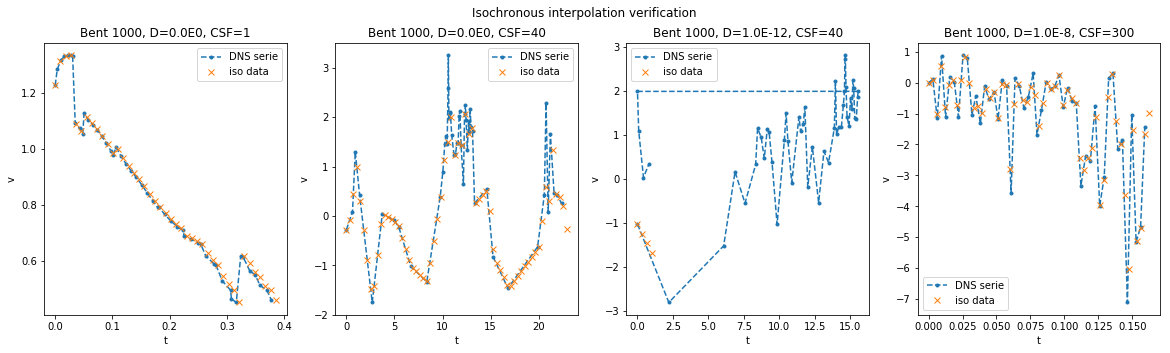

In [46]:
key    = KEYS[-1]
fig, axs = plt.subplots(1,4, figsize = (20,5))
fig.suptitle('Isochronous interpolation verification');

i0  = 0
N   = 50
for (i,key) in zip(range(4),[KEYS[0], KEYS[1],KEYS[5], KEYS[-1]]) :
    T0     = tDNS[key][i0]
    T      = tDNS[key][i0+N]
    axs[i].set_title(key)
    axs[i].plot(tDNS[key][i0:i0+N],vDNS[key][i0:i0+N],'.--', label = 'DNS serie'); #rough DNS series
    
    i0_iso = int(np.ceil(T0/dt_iso[key]))
    N_iso  = int(np.ceil((T-T0)/dt_iso[key]))
    t_iso  = np.linspace(T0,T,N_iso)
    axs[i].plot(t_iso,v_iso[key][i0_iso:i0_iso+N_iso],'x',label='iso data'); #Isochronous series

    axs[i].set_xlabel('t');
    axs[i].set_ylabel('v');
    axs[i].legend();
plt.savefig(DIR+'Figures/check_iso_transf'+extension)

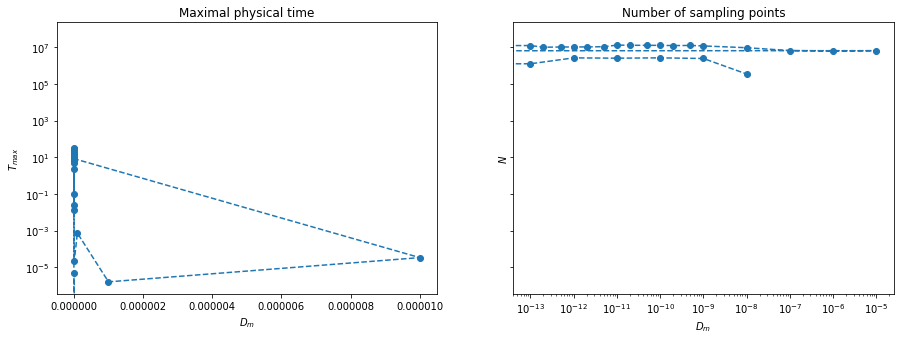

In [69]:
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey = True);
axs[0].set_title('Maximal physical time');
axs[0].semilogy(D_VALUES,[tDNS[k_][-1] for k_ in KEYS],'--o');
axs[0].set_xlabel(r'$D_m$');
axs[0].set_ylabel(r'$T_{max}$');

axs[1].set_title('Number of sampling points');
axs[1].loglog(D_VALUES,[len(tDNS[k_]) for k_ in KEYS],'--o');
axs[1].set_xlabel(r'$D_m$');
axs[1].set_ylabel(r'$N$');

### Comparison with Markovian processes

In [48]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=NCORES_MAX)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Loading data...
Done


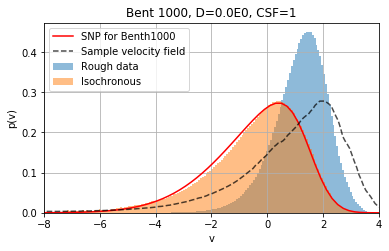

In [66]:
#PLOT_KEYS = [PLOT_KEYS_40[i] for i in [0,1,3,5,8,9,10]]
PLOT_KEYS = PLOT_KEYS_1
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, ax = plt.subplots(1,1,figsize=(6,3.5), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in PLOT_KEYS:
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    ax.set_title('' + key)
    #axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5, color = color_cycle[2])
    ax.hist(data1, bins = 200, label ='Rough data',         density = True, alpha= 0.5, color = color_cycle[0])
    ax.hist(data2, bins = 200, label ='Isochronous', density = True, alpha= 0.5, color = color_cycle[1])
    ax.plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000', color = 'r');
    ax.plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Sample velocity field', alpha=0.7);
    ax.grid(True)
    ax.set_xlabel('v')
    ax.set_ylabel('p(v)')
    ax.legend()
    ax.set_xlim([-8,4])
plt.savefig(DIR+'Figures/LVM_pdf_DM=0'+extension)

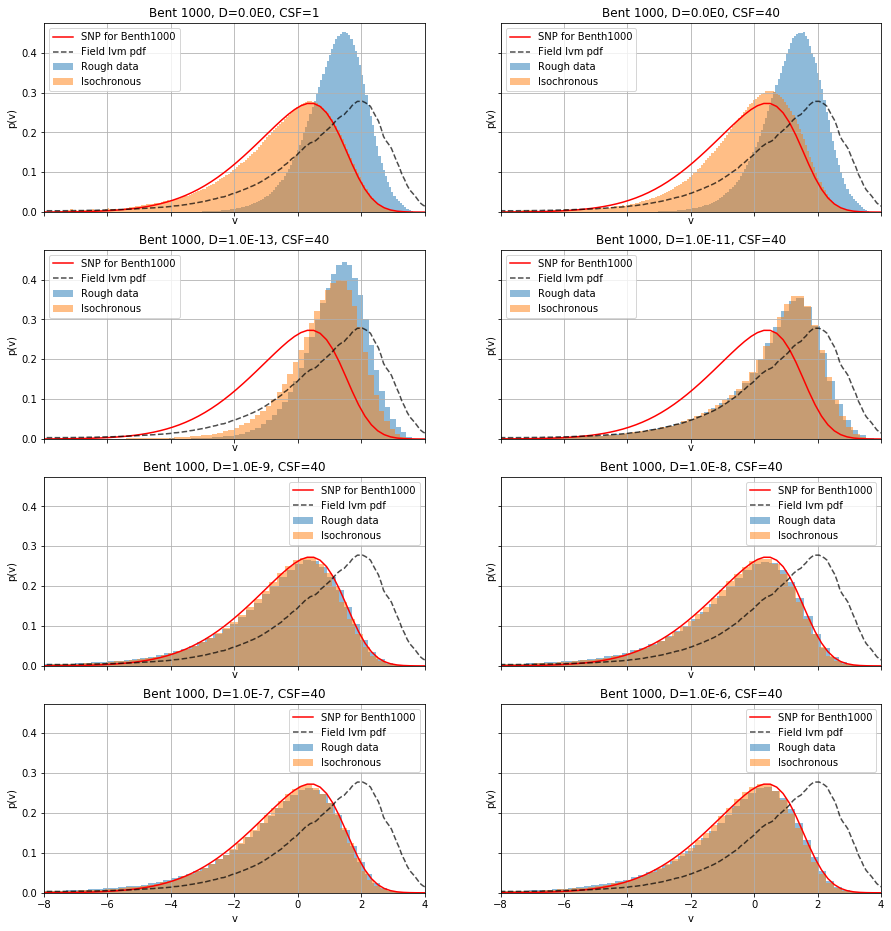

In [71]:
#PLOT_KEYS = [PLOT_KEYS_40[i] for i in [0,1,3,5,8,9,10]]
PLOT_KEYS = PLOT_KEYS_1 + PLOT_KEYS_40[:-1]
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, axs = plt.subplots(int(len(PLOT_KEYS)/2),2,figsize=(15,4*int(len(PLOT_KEYS)/2)), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in PLOT_KEYS:
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('' + key)
    #axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5, color = color_cycle[2])
    axs[i,j].hist(data1, bins = 200, label = 'Rough data',         density = True, alpha= 0.5, color = color_cycle[0])
    axs[i,j].hist(data2, bins = 200, label = 'Isochronous', density = True, alpha= 0.5, color = color_cycle[1])
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000', color = 'r');
    axs[i,j].plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Field lvm pdf', alpha=0.7);
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-8,4])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/LVM_pdf_comparison'+extension)

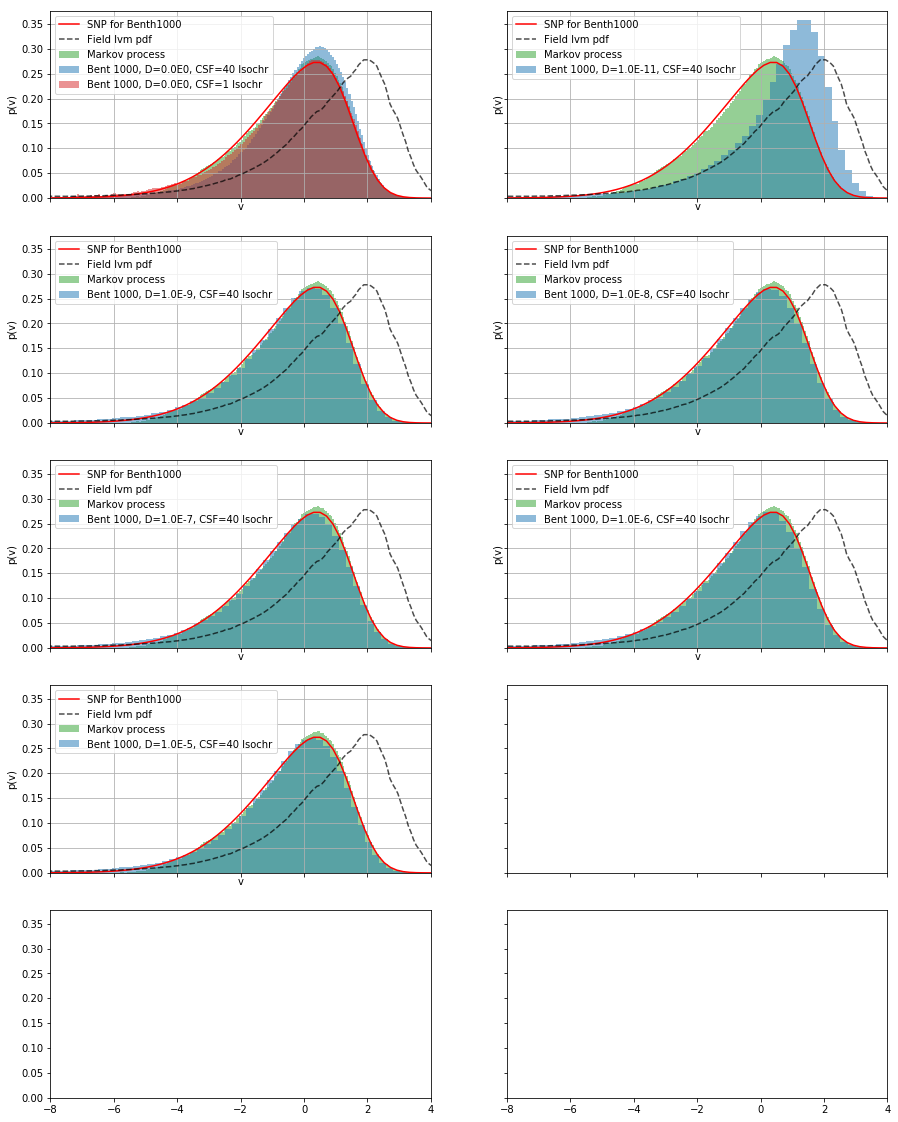

In [72]:
#PLOT_KEYS = [PLOT_KEYS_40[i] for i in [0,1,3,5,8,9,10]]
PLOT_KEYS = PLOT_KEYS_300
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, axs = plt.subplots(5,2,figsize=(15,20), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for (k40_,k300_) in zip([PLOT_KEYS_40[i] for i in [0,2,3,4,5,6,7]],PLOT_KEYS_300):
    data1 = v_iso[k40_]
    data2 = v_iso[k300_]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5, color = color_cycle[2])
    axs[i,j].hist(data1, bins = 200, label = k40_+' Isochr',         density = True, alpha= 0.5, color = color_cycle[0])
   # axs[i,j].hist(data2, bins = 200, label = k300_+' Isochr', density = True, alpha= 0.5, color = color_cycle[1])
    if i+j == 0 :
            axs[i,j].hist(v_iso[KEYS_1[0]], bins = 200, label = KEYS_1[0]+' Isochr', density = True, alpha= 0.5, color = color_cycle[3])
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000', color = 'r');
    axs[i,j].plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Field lvm pdf', alpha=0.7);
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-8,4])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/summary'+extension)

#### Computation of LVM PDF

In [51]:
pdf_vDNS     = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_vDNS_fname = DIR+'Processed_data/pdf_vDNS.dat'
pdf_viso     = {} #to store isochronous histogram as a line
pdf_viso_fname = DIR+'Processed_data/pdf_viso.dat'
    
if os.path.isfile(pdf_vDNS_fname): 
    print('Loading vDNS pdf..')
    pdf_vDNS = Load_pdf(pdf_vDNS_fname)
if os.path.isfile(pdf_viso_fname): 
    print('Loading viso pdf..')
    pdf_viso = Load_pdf(pdf_viso_fname)

SAVE = False
for key in KEYS :
    if key not in pdf_vDNS :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_vDNS[key] = Extract_pdf(vDNS[key])
        pdf_viso[key] = Extract_pdf(v_iso[key])

if SAVE :     
    print('\tSaving..')
    Save_pdf(pdf_vDNS, pdf_vDNS_fname)
    Save_pdf(pdf_viso, pdf_viso_fname)
print('Done.')


Loading vDNS pdf..
Loading viso pdf..
Done.


#### Computation of directional velocity PDF